In [ ]:
import json
import os
import math
import librosa
 
DATASET_PATH = "/content/drive/MyDrive/genres"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
 
 
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """
 
    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }
 
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
 
    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
 
        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:
 
            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))
 
            # process all audio files in genre sub-dir
            for f in filenames:
 
        # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
 
                # process all segments of audio file
                for d in range(num_segments):
 
                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
 
                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T
 
                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))
 
    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/genres/disco/disco.00004.wav, segment:5
/content/drive/MyDrive/genres/disco/disco.00004.wav, segment:6
/content/drive/MyDrive/genres/disco/disco.00004.wav, segment:7
/content/drive/MyDrive/genres/disco/disco.00004.wav, segment:8
/content/drive/MyDrive/genres/disco/disco.00004.wav, segment:9
/content/drive/MyDrive/genres/disco/disco.00004.wav, segment:10
/content/drive/MyDrive/genres/disco/disco.00002.wav, segment:1
/content/drive/MyDrive/genres/disco/disco.00002.wav, segment:2
/content/drive/MyDrive/genres/disco/disco.00002.wav, segment:3
/content/drive/MyDrive/genres/disco/disco.00002.wav, segment:4
/content/drive/MyDrive/genres/disco/disco.00002.wav, segment:5
/content/drive/MyDrive/genres/disco/disco.00002.wav, segment:6
/content/drive/MyDrive/genres/disco/disco.00002.wav, segment:7
/content/drive/MyDrive/genres/disco/disco.00002.wav, segment:8
/content/drive/MyDrive/genres/disco/disco.00002.wav, segment:9
/co

Data succesfully loaded!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1690)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               865792    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
219/219 [==============================] - 6s 23ms/step - loss: 14.9953 - ac

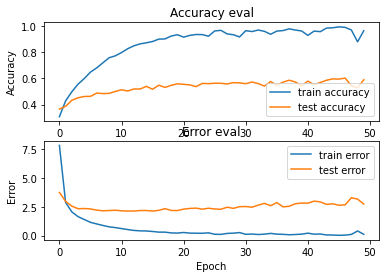

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/data_10.json"

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

def plot_history(history):

      fig, axs = plt.subplots(2)

      # create accuracy sublpot
      axs[0].plot(history.history["accuracy"], label="train accuracy")
      axs[0].plot(history.history["val_accuracy"], label="test accuracy")
      axs[0].set_ylabel("Accuracy")
      axs[0].legend(loc="lower right")
      axs[0].set_title("Accuracy eval")

      # create error sublpot
      axs[1].plot(history.history["loss"], label="train error")
      axs[1].plot(history.history["val_loss"], label="test error")
      axs[1].set_ylabel("Error")
      axs[1].set_xlabel("Epoch")
      axs[1].legend(loc="upper right")
      axs[1].set_title("Error eval")

      plt.show()


if __name__ == "__main__":

    # load data
    X, y = load_data(DATA_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # build network topology
    model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
        keras.layers.Dense(512, activation='relu'),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu'),

        # 3rd dense layer
        keras.layers.Dense(64, activation='relu'),

        # output layer
        keras.layers.Dense(10, activation='softmax')
    ])

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)
    plot_history(history)

Data succesfully loaded!
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               865792    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          

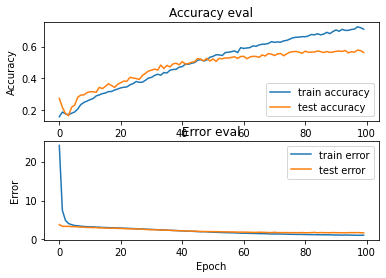

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/data_10.json"

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


if __name__ == "__main__":

    # load data
    X, y = load_data(DATA_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # build network topology
    model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
        keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # 3rd dense layer
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # output layer
        keras.layers.Dense(10, activation='softmax')
    ])

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

    # plot accuracy and error as a function of the epochs
    plot_history(history)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 32)        

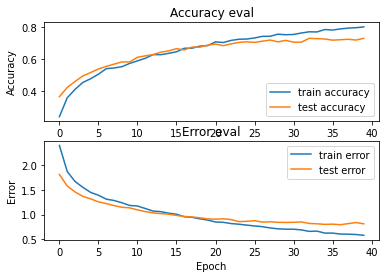

79/79 - 1s - loss: 0.8129 - accuracy: 0.7251

Test accuracy: 0.7250900268554688
Target: 8, Predicted label: [8]


In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "/content/data_10.json"


def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=40)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)

In [ ]:
X_to_predict_2 = X_test[69]
y_to_predict_2 = y_test[69]

# predict sample
predict(model, X_to_predict_2, y_to_predict_2)

Target: 3, Predicted label: [3]


In [ ]:
X_u = X
X_u = X_u.reshape(X.shape[0],X.shape[1],X.shape[2],1)
X_u.shape

(9996, 130, 13, 1)

In [ ]:
predictions_array = np.zeros(shape=(X.shape[0],1,10))

In [ ]:
X_r = X_u[4]
X_r = (X_r)[np.newaxis, ...]
X_r.shape

(1, 130, 13, 1)

In [ ]:
for i in range(X.shape[0]):
  print("Processed "+str(i))
  X_row = X_u[i]
  X_row = (X_row)[np.newaxis, ...] # array shape (1, 130, 13, 1)
  predictions_array[i] = model.predict(X_row)

Streaming output truncated to the last 5000 lines.
Processed 4996
Processed 4997
Processed 4998
Processed 4999
Processed 5000
Processed 5001
Processed 5002
Processed 5003
Processed 5004
Processed 5005
Processed 5006
Processed 5007
Processed 5008
Processed 5009
Processed 5010
Processed 5011
Processed 5012
Processed 5013
Processed 5014
Processed 5015
Processed 5016
Processed 5017
Processed 5018
Processed 5019
Processed 5020
Processed 5021
Processed 5022
Processed 5023
Processed 5024
Processed 5025
Processed 5026
Processed 5027
Processed 5028
Processed 5029
Processed 5030
Processed 5031
Processed 5032
Processed 5033
Processed 5034
Processed 5035
Processed 5036
Processed 5037
Processed 5038
Processed 5039
Processed 5040
Processed 5041
Processed 5042
Processed 5043
Processed 5044
Processed 5045
Processed 5046
Processed 5047
Processed 5048
Processed 5049
Processed 5050
Processed 5051
Processed 5052
Processed 5053
Processed 5054
Processed 5055
Processed 5056
Processed 5057
Processed 5058
Proc

In [ ]:
genre_dict = {0:'blues', 1:'classical', 2:'country', 3:'disco', 4:'hiphop', 5:'jazz', 6:'metal', 7:'pop', 8:'reggae', 9:'rock'}

In [ ]:
while(True):
  print("Genres :")
  print()
  print("blues : 0")
  print("classical : 1")
  print("country : 2")
  print("disco : 3")
  print("hiphop : 4")
  print("jazz : 5")
  print("metal : 6")
  print("pop : 7")
  print("reggae : 8")
  print("rock : 9")
  print()
  print()
  x = int(input("Select your song's genre (0-9) : "))
  s_n = int(input("Select the song number of the song you like (0-99) from " + str(genre_dict[x]) +" genre and I will recommend you top 5 similar songs, you might like : "))
  d = x*1000 + s_n*10 + 5
  ex_song = predictions_array[d]
  print()
  print("Your song's genre is : ")
  print()
  print(genre_dict[y[d]])
  print()
  print("and song number :")
  print()
  print(math.floor(((d%1000)/10)))
  min_list = []
  min_index_list = []
  min = 10000
  for i in range(9996):
    if (i!=d):
      s=np.linalg.norm(predictions_array[i][0] - ex_song[0])  
                                          
    if(s<min):
      min = s
      min_list.append(s)
      min_index_list.append(i)
  print()
  print("The top 5 songs I found most similar to the given song are : ")
  print()
  res = []
  #print(min_index_list[0])
  for i in min_index_list:
      if i not in res:
          res.append(i)
  c=-1
  for i in range(5):
    genre_name = genre_dict[int(res[c]/1000)]
    song_no = math.floor(((res[c]%1000)/10))
    print(genre_name+" song number "+str(song_no))
    c = c-1
  print()
  print()
  ans = str(input(print("Do you wish to enter more : ? (y/n)")))
  if(ans=='y'):
    continue
  else:
    break


Genres :

blues : 0
classical : 1
country : 2
disco : 3
hiphop : 4
jazz : 5
metal : 6
pop : 7
reggae : 8
rock : 9


Select your song's genre (0-9) : 1
Select the song number of the song you like (0-99) from classical genre and I will recommend you top 5 similar songs, you might like : 44

Your song's genre is : 

classical

and song number :

44

The top 5 songs I found most similar to the given song are : 

classical song number 47
classical song number 34
classical song number 13
classical song number 9
classical song number 9


Do you wish to enter more : ? (y/n)
y
Genres :

blues : 0
classical : 1
country : 2
disco : 3
hiphop : 4
jazz : 5
metal : 6
pop : 7
reggae : 8
rock : 9


Select your song's genre (0-9) : 3
Select the song number of the song you like (0-99) from disco genre and I will recommend you top 5 similar songs, you might like : 77

Your song's genre is : 

disco

and song number :

77

The top 5 songs I found most similar to the given song are : 

disco song number 64
